<h1> Manfold Learning using diffusion maps <h1>

**Q: Is the euclidean distance the best measure of similarity for large, highly nonlinear datasets?**

A: No. The reason is that a lot of times the space on which the data is defined is only locally euclidean. More simply stated, for any analysis we do on that data in its original dimensionality we may be exploring subsets of the total space of support which do not hold much data in the first place. A lot of times, this gives the dataset an artificially high dimensionality. This is a problem known as *curse of dimensionality*. 

**Q: What is a manifold? Why is it important for what I just read?**

A: A manifold is a mathematical object which globally has a definition of closeness for all the points that lie in it but it doesnt necessarily have a definition of distance between any two of them. In addition to this, it locally looks like a euclidean space. Let us start by plotting some data on a manifold. The first step as usual is to collect our tools.

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
from scipy.linalg import eigh
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
# If you dont have the package dash installed on your system, type( pip install jupyter-dash) on jupyter

In [34]:
def find_diffusion_matrix(X=None, alpha=0.15):
    """Function to find the diffusion matrix P
        
        >Parameters:
        alpha - to be used for gaussian kernel function
        X - feature matrix as numpy array
        
        >Returns:
        P_prime, P, Di, K, D_left
    """
    alpha = alpha
        
    dists = euclidean_distances(X, X)
    K = np.exp(-dists**2 / alpha)
    
    r = np.sum(K, axis=0)
    Di = np.diag(1/r)
    P = np.matmul(Di, K)
    
    D_right = np.diag((r)**0.5)
    D_left = np.diag((r)**-0.5)
    P_prime = np.matmul(D_right, np.matmul(P,D_left))

    return P_prime, P, Di, K, D_left


In [35]:
def find_diffusion_map(P_prime, D_left, n_eign=3):
    """Function to find the diffusion coordinates in the diffusion space
        
        >Parameters:
        P_prime - Symmetrized version of Diffusion Matrix P
        D_left - D^{-1/2} matrix
        n_eigen - Number of eigen vectors to return. This is effectively 
                    the dimensions to keep in diffusion space.
        
        >Returns:
        Diffusion_map as np.array object
    """   
    n_eign = n_eign
    
    eigenValues, eigenVectors = eigh(P_prime)
    idx = eigenValues.argsort()[::-1]
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    
    diffusion_coordinates = np.matmul(D_left, eigenVectors)
    
    return diffusion_coordinates[:,:n_eign]

Full disclosure, diffusion maps can be created as direct functions on publicly available subroutines of python. We are going the creation route for this one as we need to undrstand manifold dimensional reduction. The first thing to do is create a subroutine that gives us the ability to 3D-render the plot.

In [36]:
def make_plot(N=1000, rseed=12345):
    # Make a plot with "HELLO" text; save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'S', va='center', ha='center', size=85)
    fig.savefig('plot.png')
    plt.close(fig)
    fig.show()
    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('plot.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(5 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

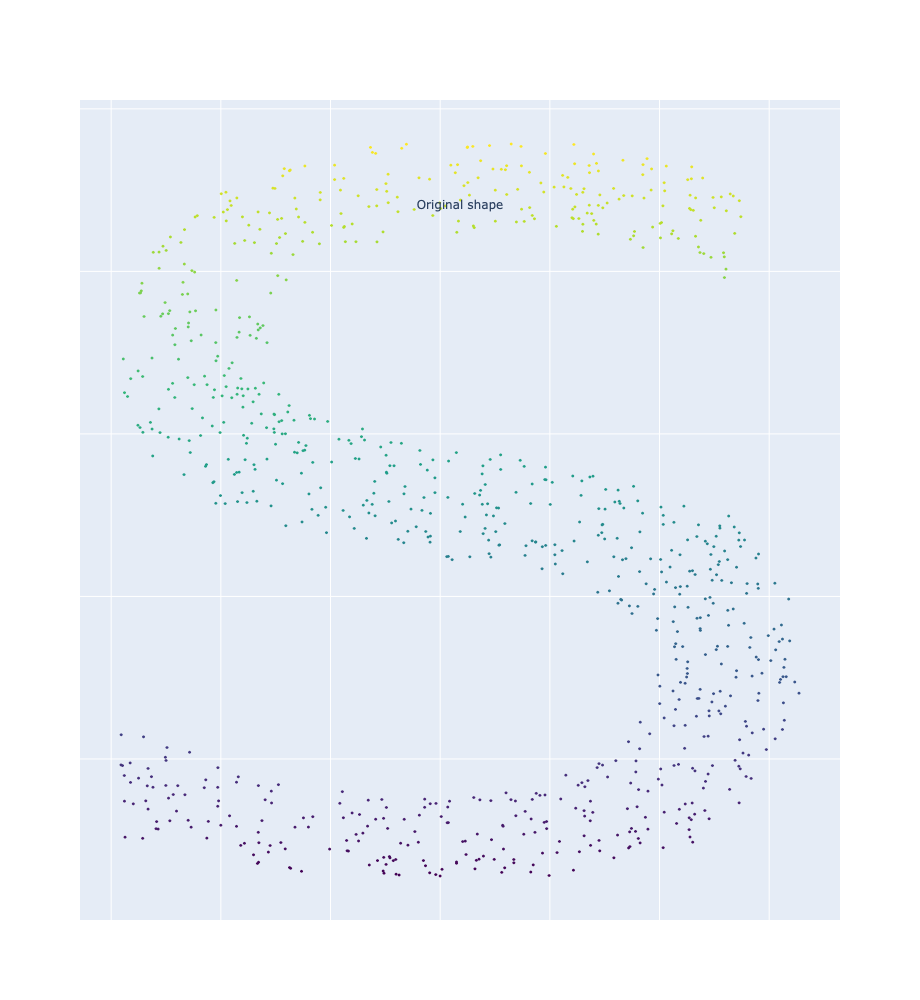

In [37]:
# Generate shape
X= make_plot(3000)
data=go.Scatter(x=X[:, 0], y=X[:, 1], mode='markers', marker=dict(size=3,color=X[:,1],opacity=1,colorscale='Viridis'))
layout=go.Layout(title_text="Original shape", title_x=0.5, title_y=0.8,title_font_size=12)
fig = go.Figure(data=[data], layout=layout)
fig.update_layout(height=1000, width=1000,showlegend=False)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.show()

In [38]:
newX = pd.DataFrame(X)
newX['dimension1'] = [random.uniform(0.1,0.5) for _ in range(len(X))]
newX = np.asarray(newX)

In [39]:
def plot_3Dfigure(newX, title='Datapoints'):
    data = go.Scatter3d(x=newX[:,0], y=newX[:,1], z=newX[:,2], mode='markers', marker=dict(
            size=2,color=newX[:,1],opacity=0.7,colorscale='Viridis'))
    layout = go.Layout(title_text=title,title_x=0.5,title_y=0.8,title_font_size=12)
    fig = go.Figure(data=[data], layout=layout)
    fig.update_layout(showlegend=False)
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)
    fig.update_layout(scene = dict(
                    xaxis = dict(title= '', ticks= '', showticklabels= False,),
                    yaxis = dict(title= '', ticks= '', showticklabels= False,),
                    zaxis = dict(title= '', ticks= '', showticklabels= False,),
                    ))
                  
    fig.show()

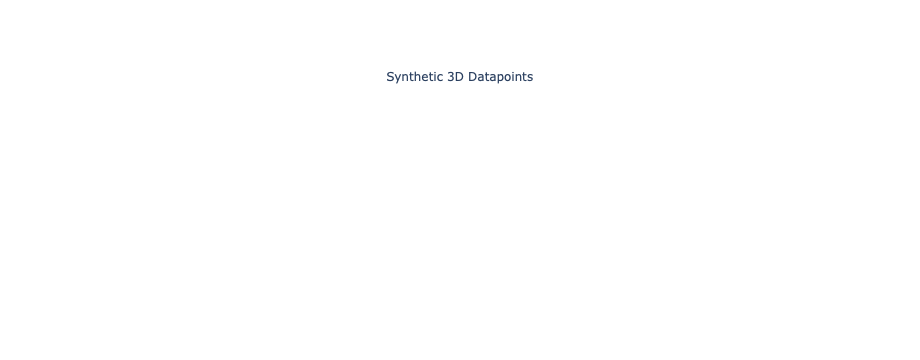

In [40]:
plot_3Dfigure(newX, title='Synthetic 3D Datapoints')

In [41]:
def plot_2Dsub_figures(d_map, alpha_values, title='Diffused points'):
    subplot_titles=[f'α={round(a,4)}' for a in alpha_values]
    fig = make_subplots(rows=2, cols=5,subplot_titles=subplot_titles)
    for i in range(1,3):
        for j in range(1,6):
            dmap_idx = i+j-1
            fig.add_trace(
                go.Scatter(x=d_map[dmap_idx][:,0], y=d_map[dmap_idx][:,1], mode='markers', marker=dict(
                size=3,color=d_map[dmap_idx][:,1],opacity=0.8,colorscale='Viridis')),row=i, col=j)

    fig.update_layout(title_text=title, title_x=0.5)
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)
    fig.update_layout(height=500, width=1000, showlegend=False)
    fig.show()

In [42]:
def apply_diffusions(alpha_start=0.001, alpha_end= 0.009, title='Diffused points'):
    d_maps = []
    alpha_values = np.linspace(alpha_start, alpha_end, 10)
    for alpha in alpha_values:
        P_prime, P, Di, K, D_left = find_diffusion_matrix(newX, alpha=alpha)
        d_maps.append(find_diffusion_map(P_prime, D_left, n_eign=2))
    return d_maps, alpha_values

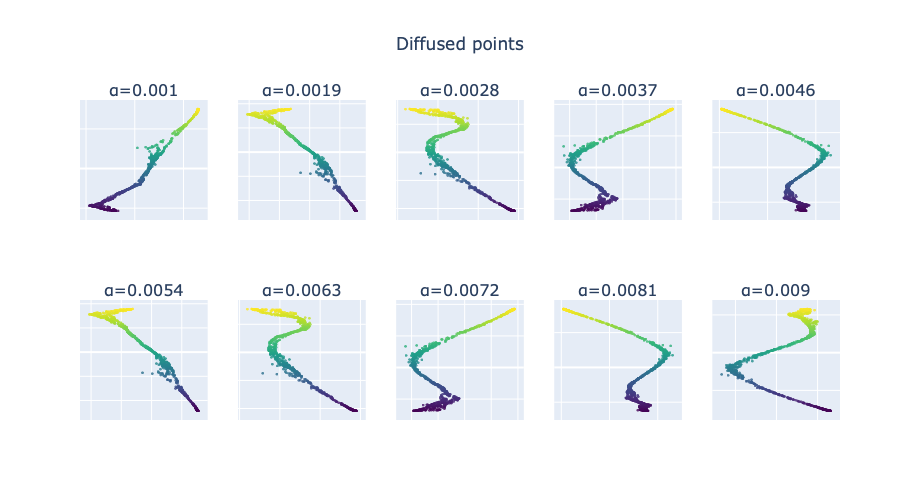

In [43]:
d_maps, alpha_values = apply_diffusions(0.001, 0.009)
plot_2Dsub_figures(d_maps,alpha_values)

In [44]:
from sklearn.manifold import TSNE

In [45]:
def apply_tsne(lr_start=10, lr_end= 1000, perplexity=30, early_exaggeration=12.0, title='Diffused points'):
    embedded_list = []
    lr_values = np.linspace(lr_start, lr_end, 10)
    for lr in lr_values:
        embedded_list.append(TSNE(n_components=2, 
                                  learning_rate=lr,
                                  perplexity=perplexity, 
                                  early_exaggeration=early_exaggeration
                                  ).fit_transform(newX))
    return embedded_list, lr_values

In [46]:
def plot_2Dsub_figures(embedded_list, lr_values, title='tSNE Embedded data'):
    subplot_titles=[f'lr={round(lr,4)}' for lr in lr_values]
    fig = make_subplots(rows=2, cols=5,subplot_titles=subplot_titles)
    for i in range(1,3):
        for j in range(1,6):
            embedded_list_idx = i+j-1
            fig.add_trace(
                go.Scatter(x=embedded_list[embedded_list_idx][:,0], y=embedded_list[embedded_list_idx][:,1], mode='markers', marker=dict(
                size=3,color=embedded_list[embedded_list_idx][:,1],opacity=0.8,colorscale='Viridis')),row=i, col=j)

    fig.update_layout(title_text=title, title_x=0.5)
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)
    fig.update_layout(height=500, width=1000, showlegend=False)
    fig.show()

In [47]:
embedded_list, lr_values = apply_tsne(perplexity=50)


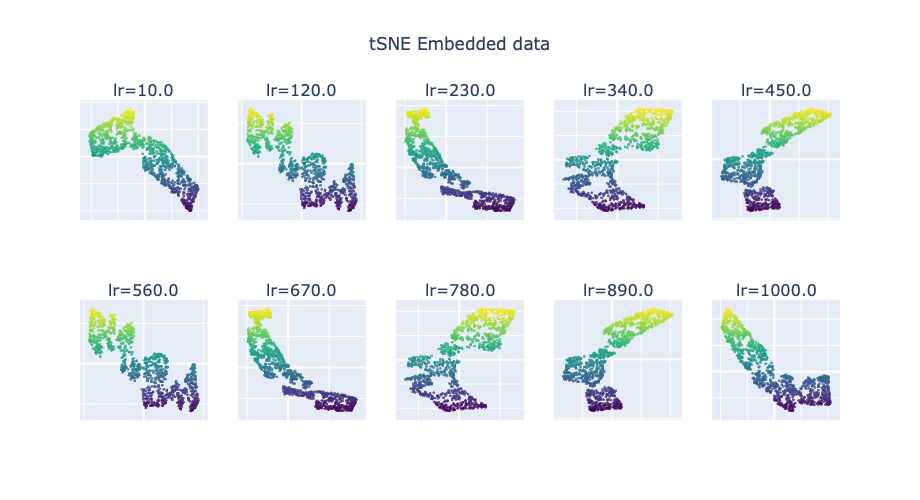

In [48]:
plot_2Dsub_figures(embedded_list, lr_values)
